<a href="https://colab.research.google.com/gist/Conal97/3f42bc8a2a312061c1e38bfd64ab30ee/inhomogeneous-lattice-szr-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mesa
import numpy as np
import math
import random


import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

**Defining Movement**

This agent is used to define how the zombie(s) can move through the grid.

In [0]:
class RandomWalker(Agent):
    '''
    Class implementing random walker methods in a generalized manner.
    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.
    '''

    grid = None
    x = None
    y = None
    moore = False

    def __init__(self, pos, model, moore=False):
        '''
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        '''
        Step one cell in any allowable direction.
        '''
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

**Defining the Susceptible class**

This agent is our susceptible, they will be placed randomly across the grid and will remain in place as the zombie moves through the grid. They can either kill the zombie, or become a zombie.

This class can be edited in the future to allow for density, movement and more (reproduction, energy, tools, different conditions of suscpetibles). 

In [0]:
class Susceptible(Agent):
  '''
  A susceptible that stays in place, and fights with zombies either becoming one or killing the zombie.

  '''
  def __init__(self, pos, model):
      super().__init__(pos, model)  
      self.pos = pos
      



**Defining the Removed class**

This agent is our removed, they are placed at the site of a zombie being killed by a susceptible. 

Again, modifications can be made to this class in the future to alter the dynamics of the model. 



In [0]:
class Removed(Agent):
    '''
    A removed that stays in place, they are the result of a zombie being killed by a susceptible. 
    
    '''

    def __init__(self, pos, model):
        super().__init__(pos, model) 
        self.pos = pos
        



**Defining the Zombie class**

This agent is our Zombie, it moves randomly around the grid. When it comes into contact with a susceptible it will fight them, either causing them to become a zombie, or will lose and become removed. 

In [0]:
class Zombie(RandomWalker):
    '''
    A zombie that walks around, and either bites or gets killed by susceptibles.
    '''

    def __init__(self,pos, model, moore):
        super().__init__(pos, model, moore=moore)
        

    def step(self):
        self.random_move()
        
        # If there are susceptibles present, attempt to bite one
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        susceptible = [obj for obj in this_cell if isinstance(obj, Susceptible)]
        zombie = [obj for obj in this_cell if isinstance(obj, Zombie)]

        if len(susceptible) > 0:
          #rate constants
          beta = 0.03
          kappa = 0.018
          #rate equations to determine what happens
          k1 = beta * len(susceptible) * len(zombie)
          k2 = kappa * len(susceptible) * len(zombie)
          K = k1 + k2

          #transtition susceptible to zombie
          if random.uniform(0.0,1.0) < k1 / K:
            #randomly choose susceptible in cell and remove it
            susceptible_to_bite = random.choice(susceptible) 
            self.model.grid._remove_agent(self.pos, susceptible_to_bite)
            self.model.schedule.remove(susceptible_to_bite) 
            #place a zombie where the susceptible was
            new_zombie = Zombie(self.pos, self.model, self.moore)
            self.model.grid.place_agent(new_zombie, new_zombie.pos)
            self.model.schedule.add(new_zombie)

          #transition zombie to removed
          else:
            #randomly choose zombie in cell and remove it
            zombie_to_remove = random.choice(zombie) 
            self.model.grid._remove_agent(self.pos, zombie_to_remove)
            self.model.schedule.remove(zombie_to_remove) 
            #place a removed where the zombie was
            new_removed = Removed(self.pos, self.model)
            self.model.grid.place_agent(new_removed, new_removed.pos)
            self.model.schedule.add(new_removed)


**Adding the scheduler**



In [0]:
from collections import defaultdict

class RandomActivationByBreed(RandomActivation):
    '''
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    Assumes that all agents have a step() method.
    '''
    agents_by_breed = defaultdict(list)

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(list)

    def add(self, agent):
        '''
        Add an Agent object to the schedule
        Args:
        agent: An Agent to be added to the schedule.
        '''

        self.agents.append(agent)
        agent_class = type(agent)
        self.agents_by_breed[agent_class].append(agent)

    def remove(self, agent):
        '''
        Remove all instances of a given agent from the schedule.
        '''

        while agent in self.agents:
            self.agents.remove(agent)

        agent_class = type(agent)
        while agent in self.agents_by_breed[agent_class]:
            self.agents_by_breed[agent_class].remove(agent)

    def step(self, by_breed=True):
        '''
        Executes the step of each agent breed, one at a time, in random order.
        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        '''
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        '''
        Shuffle order and run all agents of a given breed.
        Args:
            breed: Class object of the breed to run.
        '''
        agents = self.agents_by_breed[breed]
        random.shuffle(agents)
        for agent in agents:
            agent.step()

    def get_breed_count(self, breed_class):
        '''
        Returns the current number of agents of certain breed in the queue.
        '''
        return len(self.agents_by_breed[breed_class])

**Defining the Model**

This will run our simulation.

In [0]:
class ZombieApocalypse(Model):
    '''
    Zombie Apocalypse Model with zombie movement
    '''
    def __init__(self, height, width,
                 initial_susceptibles, initial_zombies,
                 initial_removed):
        '''
        Create a new zombie apocalpyse model with the given parameters.
        Args:
            initial_susceptibles: Number of susceptibles to start with
            initial_zombies: Number of zombies to start with
            initial_removed: Number of removed to start with
        '''

        # Set parameters
        self.height = height
        self.width = width
        self.initial_susceptibles = initial_susceptibles
        self.initial_zombies = initial_zombies
        self.initial_removed = initial_removed
       
        # Set scheduler, grid type and initialise data collector
        self.schedule = RandomActivationByBreed(self)
        self.grid = MultiGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
            {"Suseptibles": lambda m: self.schedule.get_breed_count(Susceptible),
             "Zombie": lambda m: self.schedule.get_breed_count(Zombie),
             "Removed": lambda m: self.schedule.get_breed_count(Removed)})

        # Create susceptible:
        unique_id = 0
        for i in range(self.initial_susceptibles):
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            susceptible = Susceptible((x, y), self)
            self.grid.place_agent(susceptible, (x, y))
            self.schedule.add(susceptible)

        # Create zombie
        for i in range(self.initial_zombies):
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            zombie = Zombie((x, y), self, False)
            self.grid.place_agent(zombie, (x, y))
            self.schedule.add(zombie)

        self.running = True

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

     Suseptibles  Zombie  Removed
0            199       1        0
1            199       1        0
2            199       1        0
3            199       1        0
4            199       1        0
..           ...     ...      ...
295            0      71      129
296            0      71      129
297            0      71      129
298            0      71      129
299            0      71      129

[300 rows x 3 columns]


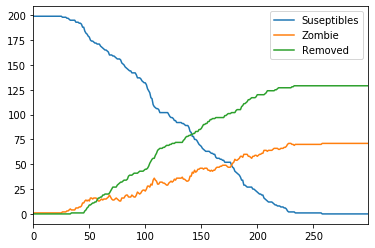

In [0]:
apocalypse = ZombieApocalypse(20, 20, 199, 1, 0)
for i in range(300):
  apocalypse.step()

# Unfortunately some runs result in an unexpected and unexplianed dictionary error. 
# Repeatedly running the cell results in a majority of succesful runs. 
# Due to limited time this error was not investigated further.

results = apocalypse.datacollector.get_model_vars_dataframe()
results.plot()
print(results)